In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

# set up and get the main data 
# get all the tables from the wikipedia page 'https://en.wikipedia.org/wiki/Nasdaq-100#Components' and write them to a pandas dataframe called WikipediaDTs
nasdaq = 'https://en.wikipedia.org/wiki/Nasdaq-100#Components'
WikipediaDTs = pd.DataFrame()
WikipediaDTs = pd.read_html(nasdaq)
len(WikipediaDTs) # this will tell us how many tables there are on the page
tickersLIST = WikipediaDTs[4]['Symbol'].tolist()
#download from yahoo finance the historical data for all tickers in the list and put it in a single dataframe called hPricesDT
hPricesDT = pd.DataFrame()
hPricesDT = yf.download(tickersLIST, start='2010-07-01', end='2021-06-30')['Close']

# identify any tickers with NaN values and list them in a list called tickersNaN
tickersNaN = []
for ticker in tickersLIST:
    if hPricesDT[ticker].isnull().values.any() == True:
        tickersNaN.append(ticker)
hPricesDT.drop(tickersNaN, axis=1, inplace=True) # drop the tickers with NaN values from the dataframe hPricesDT

hPricesDT

[*********************100%***********************]  101 of 101 completed

4 Failed downloads:
['GFS', 'GEHC', 'ARM', 'CEG']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-07-01 -> 2021-06-30) (Yahoo error = "Data doesn\'t exist for startDate = 1277956800, endDate = 1625025600")')


Ticker,AAPL,ADBE,ADI,ADP,ADSK,AEP,AMAT,AMD,AMGN,AMZN,...,SBUX,SNPS,TMUS,TSLA,TTWO,TXN,VRSK,VRTX,WBD,XEL
Date,,,,,,,,,,,,,,,,,,,,,
2010-07-01,7.485877,26.660000,19.909477,24.783220,24.570000,18.454443,9.443222,7.390000,36.582787,5.548000,...,9.491851,20.639999,13.706389,1.464000,8.850000,15.796400,29.060030,32.299999,18.441492,12.590257
2010-07-02,7.439487,26.730000,19.873819,24.608469,24.309999,18.551805,9.443222,7.170000,36.357746,5.457000,...,9.372529,20.510000,13.495021,1.280000,9.010000,15.755498,28.992676,32.220001,18.083801,12.645211
2010-07-06,7.490399,26.340000,19.888081,24.595997,24.049999,19.050108,9.270099,7.040000,36.076454,5.503000,...,9.087693,20.459999,13.543797,1.074000,8.910000,15.762307,28.915693,32.169998,18.206438,12.797860
2010-07-07,7.792867,26.790001,20.993374,25.095280,24.730000,19.685883,9.592735,7.390000,36.146790,5.671500,...,9.391771,21.480000,14.064088,1.053333,9.750000,16.532700,28.463438,33.040001,18.533470,13.048203
2010-07-08,7.775397,26.850000,20.736660,25.195133,24.610001,19.914991,9.529782,7.370000,36.730465,5.811000,...,9.561133,21.410000,14.649415,1.164000,9.390000,16.512245,28.299845,33.799999,18.564129,13.188634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-23,131.157013,574.229980,153.719040,181.660370,283.670013,72.486412,131.538193,83.820000,213.632736,175.190994,...,103.170769,268.859985,142.300369,218.856674,171.880005,167.392502,167.994263,187.520004,29.510000,59.181759
2021-06-24,130.872528,578.260010,156.922485,182.451309,286.959991,72.661819,134.217453,86.099998,215.637405,172.453995,...,103.568420,273.799988,142.859650,226.606674,175.059998,169.650192,169.569489,191.940002,30.320000,59.208565
2021-06-25,130.578201,579.659973,157.504944,183.642319,288.739990,74.345711,132.208008,85.620003,217.185699,170.072998,...,104.539474,268.970001,142.604523,223.956665,173.820007,169.254395,170.929535,194.339996,30.860001,59.959164


In [2]:
def get_signal_data(hPricesDT, signal_start_date, signal_months):
    # convert signal_start_date to a timestamp
    signal_start_date = pd.Timestamp(signal_start_date)
    
    # calculate signal_end_date as 1 year after signal_start_date
    signal_end_date = signal_start_date + pd.DateOffset(months=signal_months) + pd.DateOffset(days=-1)

    # create a dataframe called signalDT that contains the prices for the signal period
    signalDT = hPricesDT[signal_start_date:signal_end_date]

    # convert the prices to index values and put them in a dataframe called signalIndexDT
    signalIndexDT = signalDT / signalDT.iloc[0]

    # reset the signal dates to the first and last dates in the signalIndexDT dataframe index (noting that holidays and weekends will be skipped)
    signal_start_date = signalIndexDT.index[0]
    signal_end_date = signalIndexDT.index[-1]

    return signalDT, signalIndexDT, signal_start_date, signal_end_date

def get_top_bottom_tickers(signalDT, signalIndexDT, numPositions):
    
    # create a list of the top performing tickers and bottom performing tickers with the highest index numbers at the end of the period
    topPerformers = signalIndexDT.iloc[-1].nlargest(numPositions).index.tolist()
    bottomPerformers = signalIndexDT.iloc[-1].nsmallest(numPositions).index.tolist()
    otherTickers = signalIndexDT.columns.tolist()
    for ticker in topPerformers:
        otherTickers.remove(ticker)
    for ticker in bottomPerformers:
        otherTickers.remove(ticker)
    
    return topPerformers, bottomPerformers, otherTickers

def plot_signal_period(hPricesIDX, topPerformers, bottomPerformers, otherTickers):
    # create a dataframe called signalIndexDT that contains the index values for all tickers
    signalIndexDT = hPricesIDX / hPricesIDX.iloc[0]

    # plot the index for all tickers in the dataframe signalIndexDT
    plt.figure(figsize=(20,10))
    for ticker in topPerformers:
        plt.plot(signalIndexDT[ticker], color='green')
        plt.text(signalIndexDT.index[-1], signalIndexDT[ticker].iloc[-1], ticker, fontsize=12)
    for ticker in bottomPerformers:
        plt.plot(signalIndexDT[ticker], color='red')
        plt.text(signalIndexDT.index[-1], signalIndexDT[ticker].iloc[-1], ticker, fontsize=12)
    for ticker in otherTickers:
        plt.plot(signalIndexDT[ticker], color='lightgrey', linewidth='0.5')
    plt.xlabel('Date', fontsize=18)
    plt.xticks(fontsize=13)
    plt.ylabel('Price Index', fontsize=18)
    plt.yticks(fontsize=13)
    plt.title('Signal period performance - top and bottom performers', fontsize=22)
    # plot gridlines
    plt.grid(which='major', axis='both', linestyle='--')
    plt.show()

    # print the index values for the top performing tickers and bottom performing tickers
    print('Top performing tickers:')
    print(signalIndexDT[topPerformers].iloc[-1])
    print('Bottom performing tickers:')
    print(signalIndexDT[bottomPerformers].iloc[-1])

def get_long_short_portfolios(signalDT, signal_start_date, opening_portfolio_value, topPerformers, bottomPerformers, numPositions):

    # create a dataframe called longPORT that contains the long portfolio
    topPrices = signalDT.iloc[-1][topPerformers].tolist()
    topshareCount = opening_portfolio_value / numPositions / np.array(topPrices)
    longPORTinput = {'Ticker': topPerformers, 'Price': topPrices, 'ShareCount': topshareCount}
    longPORT = pd.DataFrame(longPORTinput)
    longPORT.set_index('Ticker', inplace=True)

    # create a dataframe called shortPORT that contains the short portfolio
    bottomPrices = signalDT.iloc[-1][bottomPerformers].tolist()
    bottomshareCount = opening_portfolio_value / numPositions / np.array(bottomPrices)
    shortPORTinput = {'Ticker': bottomPerformers, 'Price': bottomPrices, 'ShareCount': bottomshareCount}
    shortPORT = pd.DataFrame(shortPORTinput)
    shortPORT.set_index('Ticker', inplace=True)

    return shortPORT, longPORT
    
def run_portfolio_performance(longPORT, shortPORT, hPricesDT, trading_start_date, trading_months):
    # convert trading_start_date to a timestamp
    trading_start_date = pd.Timestamp(trading_start_date)
    
    # calculate trading_end_date as 1 year after trading_start_date
    trading_end_date = trading_start_date + pd.DateOffset(months=trading_months) + pd.DateOffset(days=-1)

    # calculate the values of the long and short portfolios over the trading period
    longPORT_values = hPricesDT[trading_start_date:trading_end_date][longPORT.index]*longPORT['ShareCount']
    shortPORT_values = hPricesDT[trading_start_date:trading_end_date][shortPORT.index]*shortPORT['ShareCount']

    # calculate the total portfolio value for each day
    longPORT_values['Total'] = longPORT_values.sum(axis=1)
    shortPORT_values['Total'] = shortPORT_values.sum(axis=1)

    return longPORT_values, shortPORT_values

def plot_portfolio_performance(longPort_values, shortPort_values):
    # plot the performance of the long and short portfolios over the trading period
    longPort_values['Total'].plot(figsize=(20,10))
    shortPort_values['Total'].plot(figsize=(20,10))
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Portfolio Value', fontsize=18)
    plt.title('Portfolio Value', fontsize=22)
    plt.legend(['Long', 'Short'], fontsize=18)
    plt.show()

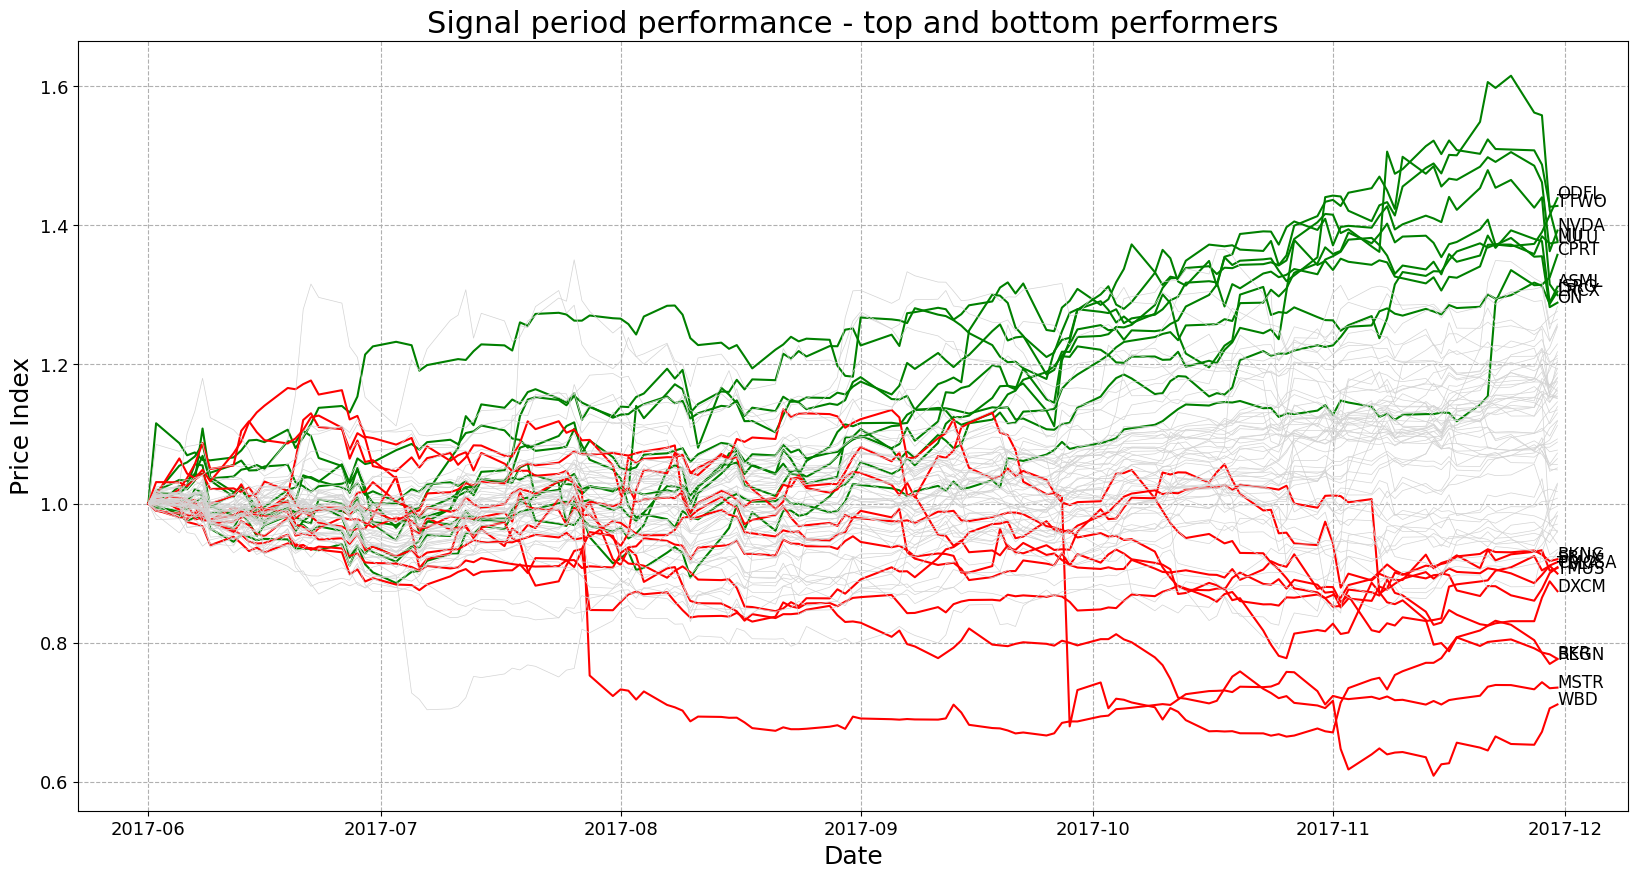

Top performing tickers:
Ticker
ODFL    1.439038
TTWO    1.427931
NVDA    1.392534
MU      1.378089
LULU    1.375796
CPRT    1.357660
ASML    1.311710
ISRG    1.304935
LRCX    1.299698
ON      1.288832
Name: 2017-11-30 00:00:00, dtype: float64
Bottom performing tickers:
Ticker
WBD      0.711294
MSTR     0.735506
REGN     0.776490
BKR      0.776796
DXCM     0.874046
TMUS     0.899411
TSLA     0.907395
CMCSA    0.908563
SBUX     0.915901
BKNG     0.920082
Name: 2017-11-30 00:00:00, dtype: float64
             Price  ShareCount
Ticker                        
ODFL     41.848186   23.895898
TTWO    111.550003    8.964590
NVDA      4.963513  201.470213
MU       41.495342   24.099090
LULU     66.959999   14.934289
CPRT     10.790000   92.678406
ASML    163.676682    6.109606
ISRG    133.259995    7.504128
LRCX     12.389661   80.712460
ON       20.080000   49.800797
              Price  ShareCount
Ticker                         
WBD       19.020000   52.576234
MSTR      13.676000   73.120797
R

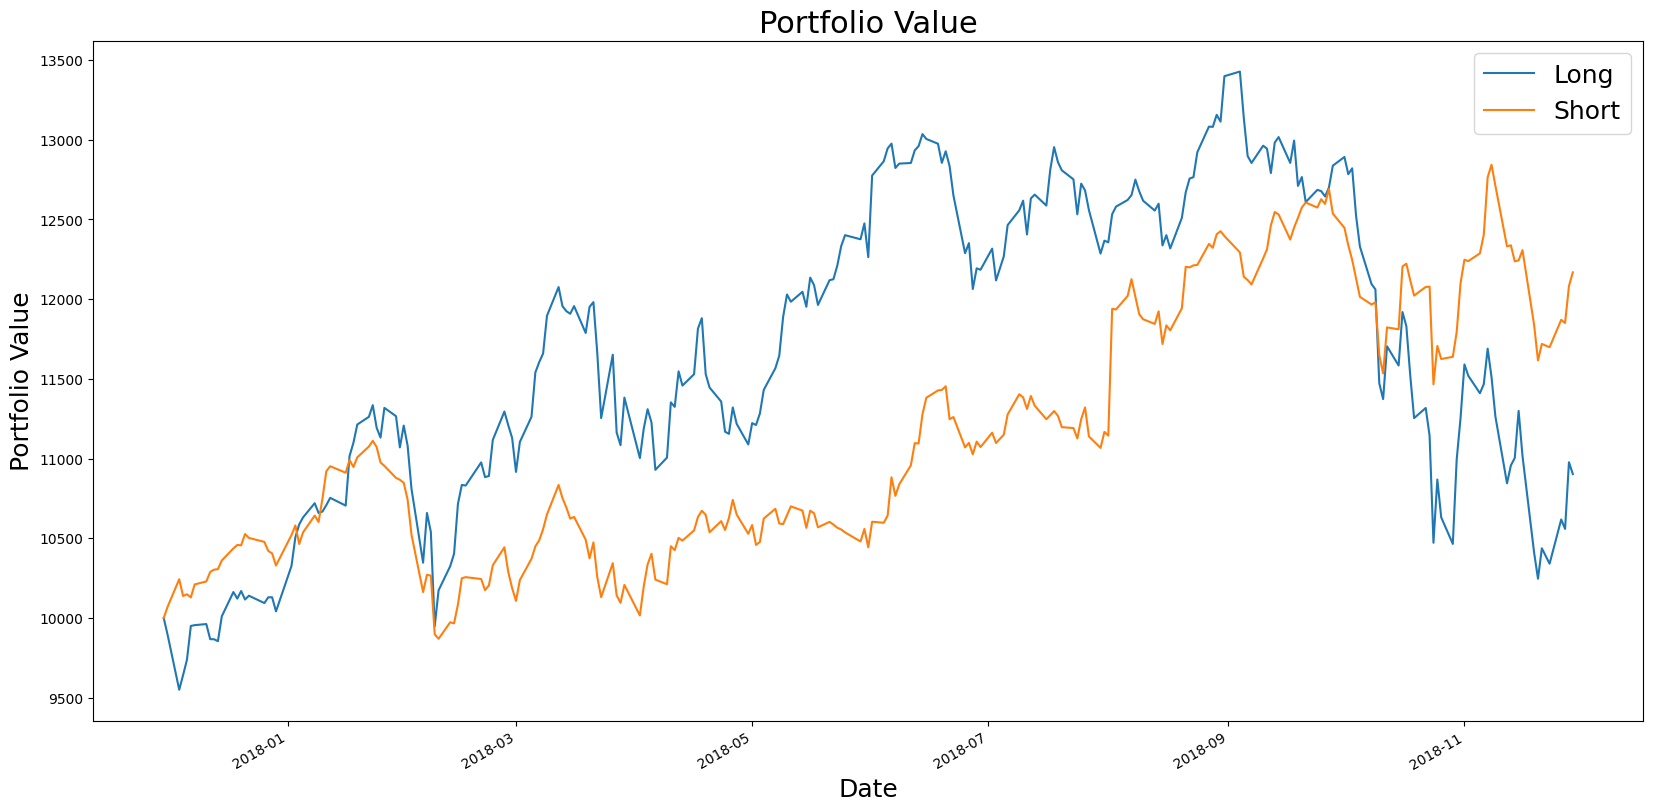

In [3]:
signal_start_date = '2017-06-01'
numPositions = 10
signal_months = 6
trading_months = 12
portfolioSize = 10000

signalDT, signalIndexDT, signal_start_date, signal_end_date = get_signal_data(hPricesDT, signal_start_date, signal_months)
topPerformers, bottomPerformers, otherPerformers = get_top_bottom_tickers(signalDT, signalIndexDT, numPositions)
plot_signal_period(signalDT, topPerformers, bottomPerformers, otherPerformers)
shortPORT, longPORT = get_long_short_portfolios(signalDT, signal_start_date, portfolioSize, topPerformers, bottomPerformers, numPositions)
print(longPORT)
print(shortPORT)
longPort_values, shortPort_values = run_portfolio_performance(longPORT, shortPORT, hPricesDT, signal_end_date, trading_months)
plot_portfolio_performance(longPort_values, shortPort_values)


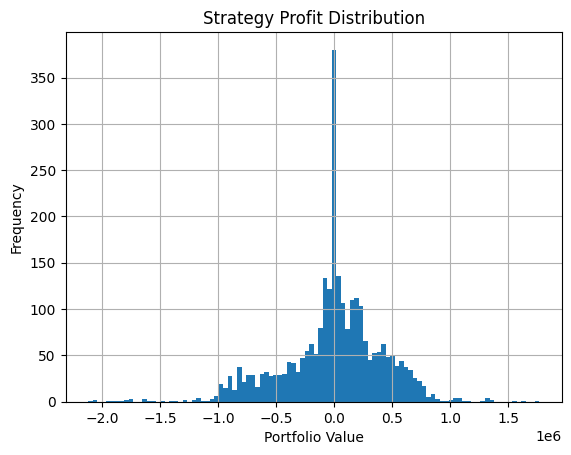

In [4]:
numPositions = 5
signal_months = 12
trading_months = 12
portfolioSize = 1000000


#create a pandas dataframe called portfolioPerformance with 3 columns: 'Long_outcome', 'Short_outcome', 'Long-Short'
portfolioPerformance = pd.DataFrame(columns=['Long_outcome', 'Short_outcome', 'Long-Short'])

rolling_period_start_dates = hPricesDT.index[0:-trading_months]

# loop through each trading period and calculate the portfolio performance
for signal_start_date in rolling_period_start_dates:
    signalDT, signalIndexDT, signal_start_date, signal_end_date = get_signal_data(hPricesDT, signal_start_date, signal_months)
    topPerformers, bottomPerformers, otherPerformers = get_top_bottom_tickers(signalDT, signalIndexDT, numPositions)
    shortPORT, longPORT = get_long_short_portfolios(signalDT, signal_start_date, portfolioSize, topPerformers, bottomPerformers, numPositions)
    longPort_values, shortPort_values = run_portfolio_performance(longPORT, shortPORT, hPricesDT, signal_end_date, trading_months)
    portfolioPerformance.loc[signal_start_date] = [longPort_values.iloc[-1]['Total'], shortPort_values.iloc[-1]['Total'], longPort_values.iloc[-1]['Total']-shortPort_values.iloc[-1]['Total']]

# show a histogram of the 'Long-Short' column
portfolioPerformance['Long-Short'].hist(bins=100)
plt.xlabel('Portfolio Value')
plt.ylabel('Frequency')
plt.title('Strategy Profit Distribution')
plt.show()



In [5]:
# calculate the mean and standard deviation of the 'Long-Short' column
mean = portfolioPerformance['Long-Short'].mean()
std = portfolioPerformance['Long-Short'].std()
print(mean, std)

-6411.009649015409 430063.9954914489
